In [1]:
import glob
import requests, zipfile, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
from sklearn.model_selection import train_test_split
import pickle

pd.options.display.float_format = '{:20,.2f}'.format # formatting

## Load Data
Data is given in separate csv files. Append to form 1 main data table. 

In [25]:
# ## Initial load

# # Download zip file ======= UNCOMMENT FOR FIRST TIME USER ================= 
# #r = requests.get("https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/data.zip")
# #z = zipfile.ZipFile(io.BytesIO(r.content))
# #z.extractall()

# # Loading features data 
# path = '../data/features'
# all_files = glob.glob(path + "/*.csv")
# df = pd.concat(pd.read_csv(f) for f in all_files)

# # Loading the labels file
# labels = pd.read_csv("../data/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [2]:
# ## Subsequent loads (to move to new notebook; ignore for now)
# # load features data ; change file path accordingly
fdir = "/Users/geri/Documents/GitHub/AMLProject_GrabSafety/data/"
fpath = fdir + "features/sorted.pkl"
data = pickle.load(open(fpath,'rb'))
labels = pd.read_csv(fdir + "labels/cleaned_labels.csv", index_col=0)


### Data Cleaning
Steps taken:
1. Remove **duplicate** bookingIDs from both datasets
2. **Sort** the dataset so we can easily compare consecutive records. 
3.	Remove **Inaccurate records**, and treat them as missing records. Inaccurate i.e.:
    - `second` >= 10000 (Drill down also shows that these high numbers are not continuous with their preceding 'correct' records.) 
    - ~~`Speed` < 0 (physically impossible)~~
4. Remove **Inaccurate trips**, i.e.:
    - ~~(?) Long trips, with largest known `second` is > 2 hours.~~ 
    - Trips where the % of data collected/entire known duration of the trip (highest recorded `second`) is < 50%.
5.	Missing Records **Imputation**
    - ONLY if the missing records are NOT consecutive for more than 5 seconds (?)
    - Some bookingIDs have missing records, including those we have removed earlier for being inaccurate. 
    - We will use rolling window to impute these missing records *only* if the gap between records is not more than 5 seconds. 

#### Remove Duplicates

In [26]:
unique_labels = labels.bookingID.value_counts()
duplicates = labels.loc[labels.bookingID.duplicated(),'bookingID']

print("There are {} unique labels, \
but a total of {} records in the labels dataset. \
This corresponds to {} records in the features dataset.".format(
    len(unique_labels), 
    len(labels), 
    df.loc[df.bookingID.isin(duplicates),'bookingID'].value_counts().sum()))

There are 20000 unique labels, but a total of 20018 records in the labels dataset. This corresponds to 18857 records in the features dataset.


In [27]:
# List of affected bookingIDs
df.loc[df.bookingID.isin(duplicates),'bookingID'].value_counts()

154618822837     2256
1649267441751    1574
1408749273124    1527
515396075694     1289
1511828488211    1245
970662608932     1237
13               1228
1348619731077    1215
455266533495     1182
403726925929     1164
919123001348      975
1391569403991     941
223338299461      656
1279900254294     626
1632087572573     584
481036337234      465
695784702084      363
395136991308      330
Name: bookingID, dtype: int64

In [28]:
# Remove duplicates from both datasets
df_clean = df[~df.bookingID.isin(duplicates)].copy()
labels_clean = labels[~labels.bookingID.isin(duplicates)].copy()

In [29]:
# Check if duplicates still exist in the features dataset
# duplicated_seconds = df_clean[df_clean.duplicated(['bookingID','second'])]
# print(len(duplicated_seconds))

In [30]:
# Sort the data for the next step 
df_sorted = df_clean.sort_values(['bookingID','second']).copy()

~~#### Inaccurate Data
When the `Accuracy` recorded in the features dataset gets too high, we notice that the `Speed` of the row can become -1, or the recorded `Second` can become extremely large. This is likely due to the GPS on the phone losing connectivity(e.g. due to car being in tunnels). Such records should be removed first. We will later impute this with the other missing records.~~ <br>
**Removed for now.**

In [9]:
# negative_records = df_sorted[df_sorted.Speed < 0]
# print('{} records have speed < 0, which is {:.2}% of df_sorted'.format(len(negative_records), len(negative_records) / len(df_sorted) * 100))
# print('These belong to {} unique booking IDs'.format(len(negative_records.bookingID.unique())))
# df_sorted[(df_sorted.Speed < 0) & (df_sorted.Accuracy > 20)].head(10)

In [10]:
# df_nonegative = df_sorted[df_sorted.Speed >= 0].copy()
# len(df_nonegative)

#### Remove Impossible records - Seconds

In [4]:
# Skipping the removal of negatives
df_nonegative = df_sorted.copy()

In [5]:
# Let's check the seconds column for records with excessively long 'known duration'
df_sorted.groupby('bookingID').agg('max').sort_values(by='second', ascending=False).head(10)

NameError: name 'df_sorted' is not defined

We may want to exclude trips that took longer than 2 hours, since it is rare that trips in Singapore would last for so long. However, the longest record is suspiciously high, let's take a closer look.

In [13]:
# Individual Drill Down: 
df_nonegative[df_nonegative.bookingID==1503238553722].tail(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
156556,1503238553722,3.90,325.00,0.78,8.66,-2.20,0.01,-0.00,0.02,396.00,18.41
903053,1503238553722,3.90,325.00,1.83,8.57,-0.79,-0.01,-0.02,0.00,397.00,18.24
744706,1503238553722,3.90,325.00,0.94,8.47,-1.83,-0.03,-0.00,0.00,398.00,18.19
1212988,1503238553722,3.90,326.00,0.19,9.35,-2.39,-0.00,-0.00,-0.01,399.00,18.39
787523,1503238553722,3.90,326.00,0.18,9.09,-1.99,-0.00,0.00,-0.00,400.00,18.58
484514,1503238553722,3.90,326.00,0.46,10.00,-2.19,0.01,0.00,0.00,401.00,18.77
332034,1503238553722,3.90,326.00,0.48,10.04,-2.18,-0.00,0.01,-0.00,402.00,18.83
10303,1503238553722,3.22,325.00,-0.06,9.65,-2.10,-0.01,0.01,0.02,403.00,19.16
1299210,1503238553722,3.90,324.00,0.17,10.08,-1.96,-0.00,0.02,0.02,404.00,19.44
1084533,1503238553722,30.64,0.00,0.33,9.64,-1.97,-0.01,0.01,0.00,"1,495,796,757.00",0.00


We should remove just this record, and keep the rest of the trip, which seem to have acceptable values. <br>
Repeated this step for the other 2 records than took > 2 hours, and found that the trips were actually that long. Will not remove.

In [6]:
# replace data with whatever copy of data you are loading 
# e.g. data = loaded pickle
df_cleanSecond = data[data.second<=10000].reset_index(drop=True).copy()

#### Remove Inaccurate Trips
Trips which have most of the data missing

In [9]:
# find % missing, i.e. % of count over maximum second of each trip 
features_agg = df_cleanSecond.groupby('bookingID')['second'].agg(['min','max','count'])
# features_agg['perc_max'] = features_agg['count'] / (features_agg['max'] + 1)
features_agg['perc_available'] = features_agg['count'] / (features_agg['max'] - features_agg['min'] + 1)

print('max value of max')
print(max(features_agg['max']))
print('max value of count')
print(max(features_agg['count']))

max value of max
8235.0
max value of count
7561


In [10]:
# Trips reportedly lasting more than an hour 
features_agg[features_agg['max'] > 3600]

,min,max,count,perc_available
bookingID,,,,
34359738469,0.00,"4,305.00",4302,1.00
60129542174,0.00,"3,688.00",434,0.12
438086664371,0.00,"8,235.00",7561,0.92
446676598842,0.00,"3,614.00",259,0.07
446676598869,0.00,"5,988.00",542,0.09
532575944853,0.00,"7,355.00",135,0.02
747324309632,0.00,"3,689.00",3674,1.00
833223655429,0.00,"3,928.00",2696,0.69
893353197656,0.00,"4,064.00",3486,0.86


/Users/geri/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/geri/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


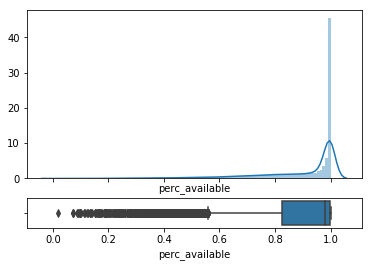

In [11]:
f, (ax_box, ax_hist) = plt.subplots(2,sharex=True, gridspec_kw={"height_ratios":(.85,.15)})
sns.boxplot(features_agg['perc_available'], ax=ax_hist)
sns.distplot(features_agg['perc_available'], bins=100, ax=ax_box)

In [12]:
perc_check = 0.5
print("There are only {} records with more than {}% of the trips missing.".format(len(features_agg[features_agg['perc_available']<perc_check]), (1-perc_check)*100))

There are only 781 records with more than 50.0% of the trips missing.


In [13]:
high_perc_missing = features_agg[features_agg.perc_available < perc_check].index
# high_perc_missing[:10]

In [16]:
df_removed50perc = df_cleanSecond[~df_cleanSecond.bookingID.isin(high_perc_missing)].copy()
labels_removed50perc = labels_clean[~labels_clean.bookingID.isin(high_perc_missing)]

In [17]:
print(len(df_cleanSecond) - len(df_removed50perc), "records removed because missing >50% of the trip.")
# We may or may not use this removed50perc.

273165 records removed because missing >50% of the trip.


In [18]:
df_removed50perc.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.00,143.30,0.82,-9.94,-2.01,-0.02,-0.09,0.07,0.00,3.44
1,0,8.00,143.30,0.55,-9.84,-2.04,-0.05,-0.08,0.04,1.00,0.23
2,0,8.00,143.30,-1.71,-9.27,-1.21,-0.03,-0.03,0.02,2.00,0.23
3,0,8.00,143.30,-1.42,-9.55,-1.86,-0.02,0.01,-0.03,3.00,0.23
4,0,8.00,143.30,-0.60,-9.85,-1.38,-0.01,-0.05,0.02,4.00,0.23


##### Visualizing Missing Data
For a single booking ID, we can visualize which part of their trip has missing data.

23741                   0.00
23742                  40.00
23743                  60.00
23744                  67.00
23745                  69.00
Name: second, dtype: float64


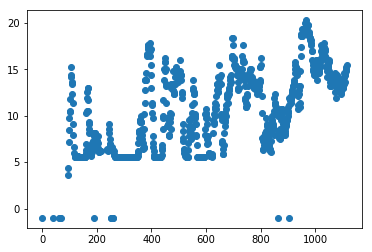

In [19]:
id = 47
print(df_cleanSecond[df_cleanSecond.bookingID == id].second.head())
plt.scatter(df_cleanSecond[df_cleanSecond.bookingID == id].second,
#             np.arange(0,len(df_cleanSecond[df_cleanSecond.bookingID == id])) # plot by the expected consecutive range of seconds
            df_cleanSecond[df_cleanSecond.bookingID == id].Speed 
           )
ls = list(df_cleanSecond[df_cleanSecond.bookingID == id].second.astype('int'))
# print(len(missing_elements(ls)))

## Cleaning missing records in a reasonable trip
1. Cut-off point for data with % missing that we cannot accept.
    - For now: 50%, the 25th percentile for the missing data. This removes 813 records only. 
    - If we reduce to 75% threshold, we will only remove 88 records.
    - By remove, I mean to remove the entire trip.
2. For each bookingID, find whether the missing records are consecutive or dispersed. 
    - If dispersed (e.g. phone only records telematics data every 5 seconds), we might be able to impute if the interval is small. 
    - If it's consecutive, go to next step
3. For chunks of missing data, find out whether the remaining data has enough value for our purposes
    - If it's one big chunk, do we still want to keep information about the other sections of the trip? (see plot about visualizing missing data below)
    - If it's several small chunks, can we get enough information out of the trip? 

Note the limitation here is that we do not know for sure whether the last known 'second' of the trip is truly the last - what if the driver ended the trip but continued to send the passenger elsewhere? I don't think this is important, but perhaps should note as an assumption.

In [20]:
## Another way to find the differences by row
# df_removed50perc[df_removed50perc.second.diff() > 5]

In [21]:
def missing_elements(L):
    """
    Finds the missing elements given a list L. 
    """
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

from itertools import groupby
from operator import itemgetter
def getConsecMissingLength(ls, length_only=True):
    """
    Input: list of integers 
        length_only (default True) to return only the length of consecutive missing
    Output: list of consecutive missing numbers (length_only=False) 
        OR list of length of each consecutive missing (length_only=True; default)
    """    
    results = []
    for k, g in groupby(enumerate(ls), lambda ix : ix[0] - ix[1]):
        if length_only:
            results.append(len(list(map(itemgetter(1),g))))
        else:
            results.append(list(map(itemgetter(1), g)))
    return results

To identify bookingIDs which we are uncomfortable with imputing:
First we need to define the unacceptable range for consecutive missing: 
- If the number of missing values is > 5 
- and if the number of missing values is within +-5 of the range of missing values

In [22]:
# threshold for consecutive missing numbers. anything >= this window this too much to impute. 
window = 5 

In [23]:
# Creating a dataframe to look specifically at the seconds data
df_t = df_cleanSecond.copy() # df_removed50perc.copy()
df_t['second'] = df_t['second'].astype('int')
df_s = pd.DataFrame(df_t.groupby('bookingID')['second'].apply(list))

# Creating columns
df_s['missing'] = df_s['second'].apply(missing_elements)
df_s['missingCount'] = df_s['missing'].str.len()
df_s['missingRange'] = (df_s['missing'].str[-1] - df_s['missing'].str[0])
df_s['missingNumbersDelta'] = df_s['missing'].apply(getConsecMissingLength)

# Reducing the size of the dataframe to only those with 5 or more missing values.
df_m = df_s[df_s.missingCount >= window]
df_m['MaxDelta'] = list(map(max, df_m['missingNumbersDelta'])) # get the maximum of the Delta

/Users/geri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
df_s.head(10)

,second,missing,missingCount,missingRange,missingNumbersDelta
bookingID,,,,,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[315, 316, 317, 318, 319, 320, 321, 322, 323, ...",586,704.00,"[585, 1]"
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",184,748.00,"[180, 1, 1, 1, 1]"
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",631,679.00,"[630, 1]"
4,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[5],1,0.00,[1]
6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,nan,[]
7,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[11, 28, 30, 37, 235, 360, 409, 587, 705, 707,...",11,781.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7...",76,305.00,"[1, 73, 1, 1]"
10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,nan,[]
11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[165, 166, 167, 168, 169, 170, 171, 172, 173, ...",75,74.00,[75]


In [25]:
df_m.head(20)

,second,missing,missingCount,missingRange,missingNumbersDelta,MaxDelta
bookingID,,,,,,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[315, 316, 317, 318, 319, 320, 321, 322, 323, ...",586,704.00,"[585, 1]",585
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",184,748.00,"[180, 1, 1, 1, 1]",180
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",631,679.00,"[630, 1]",630
7,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[11, 28, 30, 37, 235, 360, 409, 587, 705, 707,...",11,781.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7...",76,305.00,"[1, 73, 1, 1]",73
11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[165, 166, 167, 168, 169, 170, 171, 172, 173, ...",75,74.00,[75],75
16,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[36, 76, 135, 203, 364, 486, 528, 588, 628]",9,592.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",1
17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[507, 508, 509, 510, 511, 512, 517, 518, 519]",9,12.00,"[6, 3]",6
25,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[150, 151, 152, 153, 154, 155, 156, 157, 158, ...",375,374.00,[375],375


In [26]:
print("""
Out of {} bookingIDs after first round of cleaning:
{} bookingIDs have no missing values.
{} bookingIDs have missing values < 5 missing values (can be imputed).

Out of the remaining {} bookingIDs with 5 or more missing values, 
{} have 5 or more consecutive missing values that cannot be reliably imputed (should be removed).
""".format(len(df_s), 
           len(df_s[df_s.missingCount == 0]),
           len(df_s[(df_s.missingCount < window) & (df_s.missingCount > 0)]),
           len(df_m),
           len(df_m[df_m.MaxDelta>=window])
          ))


Out of 19982 bookingIDs after first round of cleaning:
4968 bookingIDs have no missing values.
3245 bookingIDs have missing values < 5 missing values (can be imputed).

Out of the remaining 11769 bookingIDs with 5 or more missing values, 
8973 have 5 or more consecutive missing values that cannot be reliably imputed (should be removed).



In [27]:
# get the bookingIDs 
to_impute = df_s[df_s.missingCount < window].index
to_impute = to_impute.append(df_m[df_m.MaxDelta < window].index)
to_remove = df_m[df_m.MaxDelta >= window].index

# print(len(to_impute), len(to_remove)) # checking

In [29]:
# removing bookingIDs with too much consecutive missing information 
df_clean_final = df_removed50perc[~df_removed50perc.bookingID.isin(to_remove)]
labels_clean_final = labels_removed50perc[~labels_removed50perc.bookingID.isin(to_remove)]
print(len(df_clean_final))
df_clean_final.head()

8485718


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
2050,4,10.00,57.71,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99
2051,4,10.00,57.71,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17
2052,4,10.00,57.71,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09
2053,4,10.00,57.71,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72
2054,4,10.00,57.71,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72


In [30]:
len(df_clean_final.bookingID.unique())

11007

After removing, only left with 8.4million records of 10477 bookingIDs. About half of the initial. Should probably relax the criteria. But at least now we have a framework for cleaning.

Use df_clean_final after running through everything for: removed missing 50 percent etc

### Changing Negative Speed to NaN


In [31]:
df_clean_final.loc[df_clean_final['Speed'] < 0, 'Speed']  = np.NaN
df_clean_final.loc[pd.isna(df_clean_final.Speed) & (df_clean_final['Bearing'] == 0), 'Bearing'] = np.NaN

df_clean_final[['Bearing', 'Speed']].isna().sum()

/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Bearing     16163
Speed      131323
dtype: int64

## Set the Index of dataframe with Datetime
In order to have the rows corressponding to a specific timestamp, a datetime column is created, which will then be set as the index. Take note that the date set at 1970-01-01 is immaterial is we are only interested in the timestamp of the data.

In [32]:
len(df_clean_final)

8485718

In [33]:
df_clean_final = df_clean_final[df_clean_final.bookingID.isin(to_impute)]

In [34]:
df_clean_final['date'] = pd.to_datetime(df_clean_final['second'], unit='s')
df_clean_final.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,date
2050,4,10.00,57.71,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99,1970-01-01 00:00:00
2051,4,10.00,57.71,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17,1970-01-01 00:00:01
2052,4,10.00,57.71,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09,1970-01-01 00:00:02
2053,4,10.00,57.71,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72,1970-01-01 00:00:03
2054,4,10.00,57.71,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72,1970-01-01 00:00:04


In [35]:
df_clean_final.set_index('date', inplace = True) 
df_clean_final.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
date,,,,,,,,,,,
1970-01-01 00:00:00,4,10.00,57.71,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99
1970-01-01 00:00:01,4,10.00,57.71,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17
1970-01-01 00:00:02,4,10.00,57.71,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09
1970-01-01 00:00:03,4,10.00,57.71,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72
1970-01-01 00:00:04,4,10.00,57.71,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72


# Checkpoint for Errors

In [2]:
fdir = "/Users/geri/Documents/GitHub/AMLProject_GrabSafety/data/"
# Save the data 
# file_pi = open(fdir + 'features/data_final.pkl', 'wb')
# pickle.dump(df_clean_final, file_pi)
# labels_clean_final.to_csv(fdir+'labels/cleaned_labels.csv')

# # Continue from here when your kernel dies 
fpath = fdir + "features/data_final.pkl"
data = pickle.load(open(fpath,'rb'))
labels = pd.read_csv(fdir + "labels/cleaned_labels.csv", index_col=0)

In [4]:
# FYI about the data; it is less than 1 GB
print(len(data))
data.info(memory_usage='deep')

8485718
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8485718 entries, 1970-01-01 00:00:00 to 1970-01-01 00:17:59
Data columns (total 11 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtypes: float64(10), int64(1)
memory usage: 776.9 MB


In [5]:
# Testing out chunking
# data.to_csv(fdir+"features/data_final.csv") # save as csv file ; only needed for first time

data_chunks = pd.read_csv(fdir+"features/data_final.csv", chunksize=10000) # read from csv in chunks
data_chunks # Outputs a TextFileReader

In [35]:
data_final = []
for chunk in data_chunks:
    df = pd.DataFrame(data_chunks.get_chunk(1))
    print(len(df))
#     # Iterate through chunks for processing
#     data_grouped = chunk.groupby('bookingID')['Speed','acceleration_x', 'acceleration_y', \
#                                              'acceleration_z','gyro_x', 'gyro_y', 'gyro_z']
#     data_rolled = data_grouped.rolling('8s', min_periods = 4)
#     data_agg = data_rolled.agg(['mean', 'median', 'std']).dropna()
#     data_final.append(data_agg)

In [41]:
for chunk in data_chunks:
    df = pd.DataFrame(chunk)
    print(len(df))
    print("hello")

In [45]:
import dask.dataframe as dd 
ddf = dd.read_csv(fdir+"features/data_final.csv") # read from csv in chunks
ddf = ddf.set_index('date').compute()
ddf.index = pd.to_datetime(ddf.index)

In [ ]:
cols = ['Speed','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x', 'gyro_y', 'gyro_z']
df1 = ddf.groupby('bookingID')[cols].apply(lambda x: x.rolling('8S').mean()).compute()

In [53]:
df1 = ddf.groupby('bookingID')[cols].apply(lambda x: x.rolling('8S').agg(['mean', 'median', 'std']).dropna()).compute()

/Users/geri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Metadata inference failed in `groupby.apply(lambda)`.

Original error is below:
------------------------
ValueError('window must be an integer',)

Traceback:
---------
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py", line 137, in raise_on_meta_error
    yield
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/dask/dataframe/groupby.py", line 1079, in apply
    meta = self._meta_nonempty.apply(func, *args, **kwargs)
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py", line 930, in apply
    return self._python_apply_general(f)
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py", line 936, in _python_apply_general
    self.axis)
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py", line 2273, in apply
    res = f(group)
  File "<ipython-input-53-5f51b4c51512>", line 3, in <lambda>
    df_rolled = ddf.groupby('bookingID').apply(lambda df_g: df_g['Speed'].rolling('8s', min_periods = 4))
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py", line 8900, in rolling
    on=on, axis=axis, closed=closed)
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/window.py", line 2469, in rolling
    return Rolling(obj, **kwds)
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/window.py", line 80, in __init__
    self.validate()
  File "/Users/geri/anaconda3/lib/python3.6/site-packages/pandas/core/window.py", line 1478, in validate
    raise ValueError("window must be an integer")


In [ ]:
# original that takes very long to run:
# df_aggregated = df_clean_final.groupby('bookingID')['Speed','acceleration_x', 'acceleration_y', 'acceleration_z','gyro_x', 'gyro_y', 'gyro_z'].rolling('8s', min_periods = 4).agg(['mean', 'median', 'std']).dropna()

## Save the cleaned data

In [39]:
# # Use df_clean_second_final for data with removed negative seconds
# labels_clean_final.to_csv("../data/labels/cleaned_labels.csv", index = False)

In [40]:
# Use df_cleanSecond for data that didnt remove negative seconds.
# df_cleanSecond.to_pickle('../data/features/data_neverRemove.pkl')

## Feature Engineering

In [73]:
def dispersion(s):
    # calculate range
    return s.max() - s.min()

In [74]:
# required column names
COL_ACCE = ('acceleration_x', 'acceleration_y', 'acceleration_z')
COL_GYRO = ('gyro_x', 'gyro_y', 'gyro_z')
COL_TELE = ('bookingID', 'Accuracy', 'Bearing', 'second', 'Speed', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z')
    
bid = df_clean_final.bookingID.unique()

In [75]:
#### STAGE 0: Data Validation ####
if not sorted(df_clean_final.columns) == sorted(COL_TELE):
    raise Exception('Input columns mismatched! Expected: \n {}'.format(COL_TELE))
     
# sort according to bookingID & seconds
df_use = df_clean_final.sort_values(['bookingID', 'second']).reset_index(drop=True)
    
# drop 'Accuracy' & 'Bearing' to save memory. we don't need these anymore. 
df_use.drop(['Accuracy', 'Bearing'], axis=1, inplace=True)

In [76]:
df_use.head()

,bookingID,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,4,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99
1,4,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17
2,4,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09
3,4,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72
4,4,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72


In [77]:
# transform triaxial gyro readings into its first principal components
from sklearn.decomposition import PCA
pca_gyro = PCA().fit(df_use.loc[:, ['gyro_x', 'gyro_y', 'gyro_z']])
pca_gyro.explained_variance_ratio_

array([0.68031479, 0.16824603, 0.15143918])

In [78]:
#### STAGE 2: Data Transformation ####
    
# calculate magnitude of acceleration sqrt(acc_x^2 + acc_y^2 + acc_z^2)
df_use['acceleration'] = np.sqrt((df_use.loc[:, COL_ACCE] ** 2).sum(axis=1))
    
df_use['gyro'] = pca_gyro.transform(df_use.loc[:, COL_GYRO])[:,0]
    

In [79]:
df_use.head(20)

,bookingID,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,acceleration,gyro
0,4,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99,9.90,-0.09
1,4,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17,9.48,-0.01
2,4,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09,9.74,-0.07
3,4,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72,9.82,-0.02
4,4,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72,9.73,-0.06
5,4,-0.40,-10.13,-0.36,-0.03,-0.08,0.00,6.00,1.18,10.15,0.08
6,4,-0.37,-9.10,-1.84,-0.07,0.02,-0.00,7.00,1.18,9.29,-0.02
7,4,-0.32,-8.95,-3.01,-0.03,0.02,-0.00,8.00,1.18,9.45,-0.02
8,4,-0.43,-9.41,-2.34,-0.00,-0.05,-0.02,9.00,2.43,9.71,0.06
9,4,-0.24,-9.12,-2.16,-0.05,-0.18,-0.02,10.00,2.43,9.37,0.19


In [80]:
#### STAGE 3A: Generating Feature (Type 1: Statistical Description) ####
    
    
feature1 = df_use.groupby('bookingID')['acceleration', 'gyro', 'Speed', 'second'].agg(['mean', 'median', 'std', dispersion]).fillna(0)
feature1.columns = ['_'.join(col) for col in feature1.columns] # rename columns
feature1.reset_index(inplace=True)

In [81]:
feature1.head()

,bookingID,acceleration_mean,acceleration_median,acceleration_std,acceleration_dispersion,gyro_mean,gyro_median,gyro_std,gyro_dispersion,Speed_mean,Speed_median,Speed_std,Speed_dispersion,second_mean,second_median,second_std,second_dispersion
0,4,9.81,9.79,0.62,13.35,-0.02,-0.02,0.11,1.16,6.15,3.31,5.60,19.78,547.50,547.50,315.96,"1,094.00"
1,6,9.92,9.90,0.59,7.28,0.00,-0.00,0.11,1.16,4.63,1.94,5.31,16.39,547.00,547.00,316.24,"1,094.00"
2,7,9.83,9.79,0.92,8.57,0.00,0.00,0.07,0.83,12.18,13.02,8.68,25.23,480.95,481.00,276.76,959.00
3,10,9.55,9.49,0.83,9.47,0.00,0.00,0.11,0.88,8.70,9.58,7.00,20.05,187.00,187.00,108.40,374.00
4,14,9.86,9.82,0.45,6.11,0.01,0.00,0.09,0.93,4.74,3.24,4.57,20.70,299.50,299.50,173.35,599.00


In [82]:
#### STAGE 3B: Generating Feature (Type 2: Detecting Outlying Behaviours) ####
    
feature2 = pd.DataFrame()

tele_iqr_20 = dict(df_use.quantile(0.2))
tele_iqr_80 = dict(df_use.quantile(0.2))

    
# use 80th percentile only
feature2['over_Speed'] = df_use.groupby('bookingID')['Speed'].apply(lambda x: sum(x > tele_iqr_80['Speed']))
# feature2['over_second'] = df_use.groupby('bookingID')['second'].apply(lambda x: sum(x > tele_iqr['second'][1]))
    
# use 20th and 80th percentile
for col in (COL_ACCE + COL_GYRO):
    feature2['over_{}'.format(col)] = df_use.groupby('bookingID')[col].apply(lambda x: sum((x < tele_iqr_20[col]) | (x > tele_iqr_80[col])))
    
feature2.reset_index(inplace=True)

In [83]:
feature2[:20]

,bookingID,over_Speed,over_acceleration_x,over_acceleration_y,over_acceleration_z,over_gyro_x,over_gyro_y,over_gyro_z
0,4,1036,1094,1094,1094,1094,1094,1094
1,6,651,1095,1095,1095,1095,1095,1095
2,7,743,949,949,949,949,949,949
3,10,278,375,375,375,375,375,375
4,14,540,600,600,600,600,600,600
5,16,411,651,651,651,651,651,651
6,18,927,1035,1035,1035,1035,1035,1035
7,21,341,465,465,465,465,465,465
8,27,1143,1215,1215,1215,1215,1215,1215
9,29,886,1170,1170,1170,1170,1170,1170


In [146]:
output = pd.DataFrame(bid, columns=['bookingID'])
output = output.merge(feature1, how='left', on='bookingID')
output = output.merge(feature2, how='left', on='bookingID')

In [147]:
output = output.merge(labels, how='left', on='bookingID')
output.head()

,bookingID,acceleration_mean,acceleration_median,acceleration_std,acceleration_dispersion,gyro_mean,gyro_median,gyro_std,gyro_dispersion,Speed_mean,...,second_std,second_dispersion,over_Speed,over_acceleration_x,over_acceleration_y,over_acceleration_z,over_gyro_x,over_gyro_y,over_gyro_z,label
0,4,9.81,9.79,0.62,13.35,-0.02,-0.02,0.11,1.16,6.15,...,315.96,"1,094.00",1036,1094,1094,1094,1094,1094,1094,1
1,6,9.92,9.90,0.59,7.28,0.00,-0.00,0.11,1.16,4.63,...,316.24,"1,094.00",651,1095,1095,1095,1095,1095,1095,0
2,7,9.83,9.79,0.92,8.57,0.00,0.00,0.07,0.83,12.18,...,276.76,959.00,743,949,949,949,949,949,949,0
3,10,9.55,9.49,0.83,9.47,0.00,0.00,0.11,0.88,8.70,...,108.40,374.00,278,375,375,375,375,375,375,0
4,14,9.86,9.82,0.45,6.11,0.01,0.00,0.09,0.93,4.74,...,173.35,599.00,540,600,600,600,600,600,600,0


In [148]:
np.random.seed(2019)
num_row = output.shape[0]
selection = np.random.choice(['train', 'test'], num_row, replace = True, p = [0.2, 0.8])
y = output['label'].values
y_train, y_test = y[selection == 'train'], y[selection == 'test']

In [149]:
from sklearn import preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

selected_cols = ['acceleration_mean', 'acceleration_median',
       'acceleration_std', 'acceleration_dispersion', 'gyro_mean',
       'gyro_median', 'gyro_std', 'gyro_dispersion', 'Speed_mean',
       'Speed_median', 'Speed_std', 'Speed_dispersion', 'second_mean',
       'second_median', 'second_std', 'second_dispersion', 'over_Speed',
       'over_acceleration_x', 'over_acceleration_y', 'over_acceleration_z',
       'over_gyro_x', 'over_gyro_y', 'over_gyro_z']
x = output[selected_cols].values
x_train, x_test = x[selection == 'train',:], x[selection == 'test',:]
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.transform(x_test)

multi_ovr_estimator = linear_model.LogisticRegression()
multi_ovr_estimator.fit(x_train, y_train)
print('Accuracy score:', multi_ovr_estimator.score(x_test, y_test))

Accuracy score: 0.8250142775556825


C:\Users\teikk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [191]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [192]:
probs = multi_ovr_estimator.predict_proba(x_test)
probs = probs[:,1]

In [194]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.73


In [195]:
fpr, tpr, thresholds = roc_curve(y_test, probs)

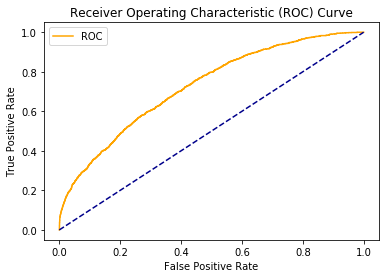

In [196]:
plot_roc_curve(fpr, tpr)

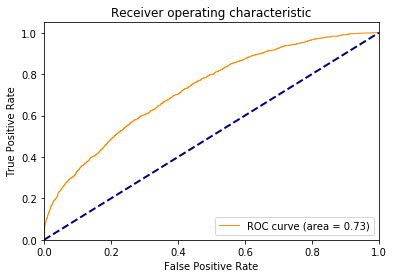

In [198]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [199]:
y_ovr_predict = multi_ovr_estimator.predict(x_test)
        
ovr_report = """
The evaluation report of OVR is:
Confusion Matrix:
{}
Accuracy: {}
""".format(confusion_matrix(y_test, y_ovr_predict),
           accuracy_score(y_test, y_ovr_predict))
print(ovr_report)


The evaluation report of OVR is:
Confusion Matrix:
[[7027   81]
 [1451  196]]
Accuracy: 0.8250142775556825



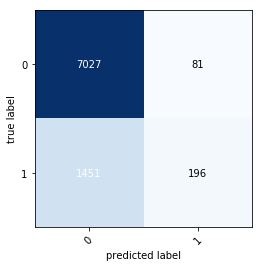

In [200]:
#import sys
#!{sys.executable} -m pip install mlxtend

# Alternative confusion matrix with labels
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_ovr_predict), class_names = [0,1])
plt.show()
plt.close()

In [201]:
print('The classification report of OVR:\n {}'
      .format(classification_report(y_test, y_ovr_predict)))

The classification report of OVR:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      7108
           1       0.71      0.12      0.20      1647

   micro avg       0.83      0.83      0.83      8755
   macro avg       0.77      0.55      0.55      8755
weighted avg       0.81      0.83      0.77      8755

